# Model-Based Sonification using mesonic

This notebooks shows how a Model-Based Sonification can be implemented using mesonic.

In [1]:
import mesonic

In [2]:
import sc3nb as scn

In [3]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist, euclidean

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

## Preparation of Synths

Lets start by preparing our Context and Synths.

In [5]:
context = mesonic.create_context()

<IPython.core.display.Javascript object>

Starting sclang process... Done.
Registering OSC /return callback in sclang... Done.
Loading default sc3nb SynthDefs... Done.
Booting SuperCollider Server... Done.


In [6]:
context.enable_realtime()

Playback(time=0.0003266334533691406, rate=1)

The model we use allows to interact with it using the mouse.

For this we create a additional SynthDef as a click marker.

In [7]:
scn.SynthDef("noise", r"""
{ |out=0, freq=2000, rq=0.02, amp=0.3, dur=1, pos=0 |
    Out.ar(out, Pan2.ar(
        BPF.ar(WhiteNoise.ar(10), freq, rq) 
        * Line.kr(1, 0, dur, doneAction: 2).pow(4), pos, amp));
}""").add()

'noise'

In [8]:
test = context.synths.create("noise", mutable=False)

In [9]:
test.start()

## Data Preparation

We also prepare the data for the sonification.

We will use the [Palmer penguins dataset](https://allisonhorst.github.io/palmerpenguins/) for the examples.

In [10]:
df = sns.load_dataset("penguins")
df = df.dropna(subset=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"])
df = df.reset_index(drop=True)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
329,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
330,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
331,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [11]:
%matplotlib inline

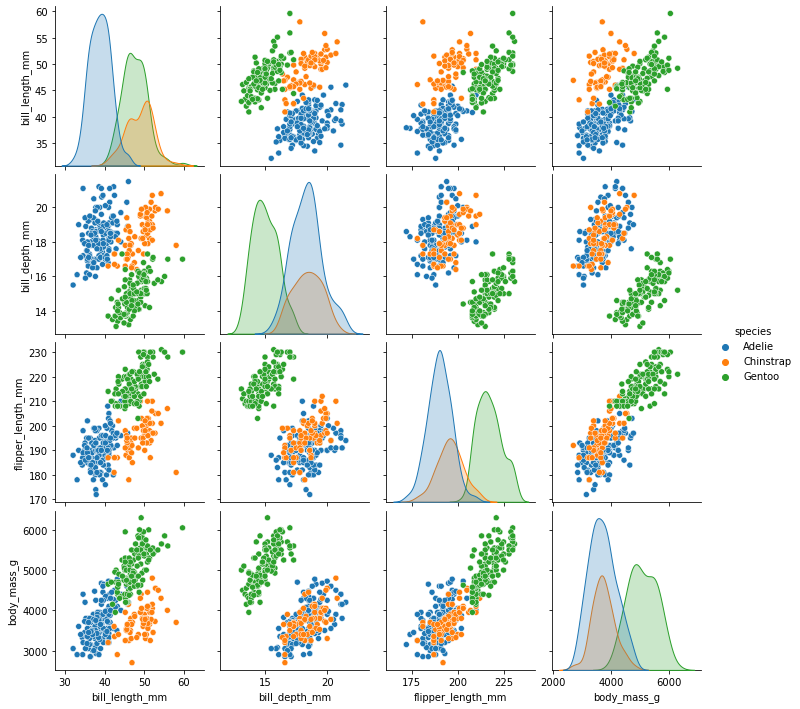

In [12]:
sns.pairplot(data=df, hue="species")

## Data Sonogram


The `DataSonogram` implements a Data Sonogram


- The model gets a dataset which is plotted in two dimensions.
- Imagine that for each point in the provided dataset a spring is created.
- The data label of the point defines the stiffness of the spring.
- When the user clicks into the plot a shock wave (signaled by noise Synth) is created from the nearest data point.
- The shock wave excites the springs as it is spreading.
- The resulting sonification can reveal clusters.


More details about the Data Sonogram and Model-Based Sonification in general can be found in the [corresponding Sonification Handbook Chapter](https://sonification.de/handbook/chapters/chapter16/)

In [13]:
class DataSonogram:

    def __init__(self, context, df, x, y, label, max_duration=1.5, spring_synth="s1", trigger_synth="noise"):
        self.context = context
        
        #prepare synths
        self.trigger_synth = context.synths.create(trigger_synth, mutable=False)
        self.spring_synth = context.synths.create(spring_synth, mutable=False)
        
        # save dataframe
        self.df = df
        self.numeric_df = df.select_dtypes(include=[np.number])
        
        # check if x and y are valid
        allowed_columns = self.numeric_df.columns
        assert x in allowed_columns, f"x must be in {allowed_columns}"
        assert y in allowed_columns, f"y must be in {allowed_columns}"

        # prepare data for model
        self.labels = self.df[label]
        self.unique_labels = self.labels.unique()
        label2id = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.numeric_labels = [label2id[label] for label in self.labels]
        self.xy_data = self.numeric_df[[x,y]].values 
        self.data = self.numeric_df.values

        # get the convex hull of the data
        hull = ConvexHull(self.data)
        hull_data = self.data[hull.vertices,:]
        # get distances of the data points in the hull 
        hull_distances = cdist(hull_data, hull_data, metric='euclidean')
        self.max_distance =  hull_distances.max()
        
        # set model parameter
        self.max_duration = max_duration
        
        # prepare plot
        self.fig = plt.figure(figsize=(5,5))
        self.ax = plt.subplot(111)

        # plot data
        sns.scatterplot(x=x, y=y, hue=label, data=df, ax=self.ax)
        
        # set callback
        def onclick(event):
            if event.inaxes is None: # outside plot area
                return
            if event.button != 1: # ignore other than left click 
                return
            click_xy = np.array([event.xdata, event.ydata])
            self.create_shockwave(click_xy)
        
        self.fig.canvas.mpl_connect('button_press_event', onclick)

    def create_shockwave(self, click_xy):
        self.context.reset()
        
        with self.context.now() as start_time:
            self.trigger_synth.start()
        # find the point that is the nearest to the click location
        center_idx = np.argmin(np.linalg.norm(self.xy_data - click_xy, axis=1))
        center = self.data[center_idx]
        # get the distances from the other points to this point
        distances_to_center = np.linalg.norm(self.data - center, axis=1)
        # get idx sorted by distances
        order_of_points = np.argsort(distances_to_center)
        # for each point create a sound using the spring synth
        for idx in order_of_points:
            distance = distances_to_center[idx]
            nlabel = self.numeric_labels[idx]
            n = len(self.unique_labels)-1
            onset = (distance / self.max_distance) * self.max_duration
            with self.context.at(start_time + onset):
                self.spring_synth.start(
                    freq = 2 * (400 + 100 * nlabel),
                    amp = scn.dbamp(scn.linlin(distance, 0, self.max_distance, -10, -30)),
                    pan = [-1,1][int(self.xy_data[idx, 0]-click_xy[0] > 0)],
                    dur = 0.04,
                    info = {"label": self.labels[idx]},
                )

To interact with the plot we use qt as matplotlib backend

In [14]:
%matplotlib qt

The `x` and `y` value can be setted to one of the numeric columns of the data set

In [15]:
numeric_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Create two views of the model with different `x` and `y` value

In [16]:
dsg1 = DataSonogram(context, df, x="flipper_length_mm", y="body_mass_g", label="species")

In [17]:
dsg2 = DataSonogram(context, df, x="bill_length_mm", y="bill_depth_mm", label="species")

We can enable the `fast_mode` of the `Clock` as the onsets will be very close.

- The `fast_mode` is a workaround that will make the Playback worker skip `time.sleep`
- `time.sleep` sleeps too long on Windows for many tasks
- The upcomming Python 3.11 will fix this: https://docs.python.org/3.11/whatsnew/3.11.html#time

In [18]:
context.realtime_playback.clock.fast_mode  # default is False

False

In [19]:
context.realtime_playback.clock.fast_mode = True

In [20]:
context.realtime_playback.clock.fast_mode = False

Disable the `fast_mode` of the `Clock` if you want to do something different like creating a new Data Sonogram as the `fast_mode` keeps the [GIL](https://wiki.python.org/moin/GlobalInterpreterLock) busy.

## Filtering the MBS

The MBS can be filtered using the `processor.event_filter`

- Lets create a helper that provides us with a filter function for the labels 

In [21]:
def create_label_filter(allowed):
    def label_filter(event):
        label = event.info.get("label", None)
        if label:
            return event if label in allowed else None
        return event
    return label_filter

Select a filter and click again on the plot to listen to the filtered result.

In [22]:
context.processor.event_filter = create_label_filter(["Chinstrap", "Gentoo"])

In [23]:
context.processor.event_filter = create_label_filter(["Adelie", "Gentoo"])

In [24]:
context.processor.event_filter = create_label_filter(["Adelie", "Chinstrap"])

In [25]:
context.processor.event_filter = create_label_filter(["Chinstrap"])

In [26]:
context.processor.event_filter = create_label_filter(["Adelie"])

In [27]:
context.processor.event_filter = create_label_filter(["Gentoo"])

- We can also remove the panning from the Events

    - This can help to identify the same point in the two different views

In [28]:
def pan_filter(event):
    pan = event.data.get("pan", None)
    if pan:
        event.data["pan"] = 0
    return event

In [29]:
context.processor.event_filter = pan_filter

Setting the filter to `None` will reset it

In [30]:
context.processor.event_filter = None

In [31]:
context.close()

Quitting SCServer... Done.
Exiting sclang... Done.
